# CLASSIFY IMAGES OF COLON CANCER ACCORDING TO CELL TYPES

## WALKTHROUGH

The dataset provided to us is a modeified version of CRCHistoPhenotypes divided into two datasets, data_labels_mainData.csv and data_labels_extraData.csv. Given the correct classifcation of cell types is provided in data_labels_mainData.csv, the same dataset and the images provided would be used to train multiple Convolutional Neural Networks to predict the classification of different cell types. The given dataset consists of a few histological colon cancer nuclie patches belonging to four classes, "fibroblast", "inflammatory", "epithelial" and "other" samples namely. The dataset consists of 27x27 RGB images of colon cells from 99 different patients, for the first 60 patients, the medical experts provided isCancerous and cell type both, which is the data that would be used for classification. The following notebook will consist of exploring the data provided to us to get an insight of the labelled patch images. Following the exploration of data, certain Convolutional Neural Network based models would be trained and commpared based on certain performance metrics

### ENVIRONMENT CONFIGURATION

In [2]:
#**************************************
# IMPORTING PACKAGES
#**************************************
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number"
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
#from tqdm import tqdm_notebook,trange
import keras,cv2
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K 
from __future__ import print_function
from tensorflow import keras
from keras.utils import np_utils
# from keras.utils import to_categorical

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
from sklearn.model_selection import train_test_split
import numpy as np
import re
import os
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
import time

start_time = 0
#import staintools
import gc

A relevant path is defined to configure the images provided to us on our local system. Make sure the path is adapted while running the notebook locally if required.
A pandas dataframe is loaded and filled with the images which is then mapped with the Instance Id of the patients provided in the "data_labels_mainData.csv" dataset. A new dataframe is created by merging the labels and other data based on Instance ID of patients to be used for exploratory data analysis

In [22]:
path = "./Image_classification_data/" #adapt this path, when running locally
train_path = path + 'patch_images/'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.png'))}) # load the filenames
print(df)

df['InstanceID'] = df.path.map(lambda x: int(x.split('/')[3].split(".")[0]))
print(df.dtypes)
labels = pd.read_csv(path+"data_labels_mainData.csv") # read the provided labels
print(labels.dtypes)

df = pd.merge(df, labels, on='InstanceID', how='right')


df.head(10)

                                                    path
0      ./Image_classification_data/patch_images/14048...
1      ./Image_classification_data/patch_images/2726.png
2      ./Image_classification_data/patch_images/13097...
3      ./Image_classification_data/patch_images/16277...
4      ./Image_classification_data/patch_images/6242.png
...                                                  ...
20275  ./Image_classification_data/patch_images/4320.png
20276  ./Image_classification_data/patch_images/19561...
20277  ./Image_classification_data/patch_images/14072...
20278  ./Image_classification_data/patch_images/17676...
20279  ./Image_classification_data/patch_images/11202...

[20280 rows x 1 columns]
path          object
InstanceID     int64
dtype: object
InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object


path  InstanceID  patientID  \
0  ./Image_classification_data/patch_images/22405...       22405          1   
1  ./Image_classification_data/patch_images/22406...       22406          1   
2  ./Image_classification_data/patch_images/22407...       22407          1   
3  ./Image_classification_data/patch_images/22408...       22408          1   
4  ./Image_classification_data/patch_images/22409...       22409          1   
5  ./Image_classification_data/patch_images/22410...       22410          1   
6  ./Image_classification_data/patch_images/22411...       22411          1   
7  ./Image_classification_data/patch_images/22412...       22412          1   
8  ./Image_classification_data/patch_images/22413...       22413          1   
9  ./Image_classification_data/patch_images/22414...       22414          1   

   ImageName cellTypeName  cellType  isCancerous  
0  22405.png   fibroblast         0            0  
1  22406.png   fibroblast         0            0  
2  22407.png   fibroblast         0            0  
3  22408.png   fibroblast         0            0  
4  22409.png   fibroblast         0            0  
5  22410.png   fibroblast         0            0  
6  22411.png   fibroblast         0            0  
7  22412.png   fibroblast         0            0  
8  22413.png   fibroblast         0            0  
9  22414.png   fibroblast         0            0

Next up is to check if any of the columns in our user created data frame consists of any null values. To do so, isnull() function of pandas is used.

In [23]:
df.isnull().values.any()

False

As for the given task, the focus is to observe relationship between the images based on the celltype, thus "isCancerous" column would be dropped using drop() function in pandas

In [24]:
df=df.drop('isCancerous',1)

In [25]:
df_extra = pd.DataFrame({'path': glob(os.path.join(train_path,'*.png'))}) # load the filenames
print(df_extra)

df_extra['InstanceID'] = df_extra.path.map(lambda y: int(y.split('/')[3].split(".")[0]))
print(df_extra.dtypes)
labels_extra = pd.read_csv(path+"data_labels_extraData.csv") # read the provided labels
print(labels_extra.dtypes)

df_extra = pd.merge(df_extra, labels_extra, on='InstanceID', how='right')
df_extra.head(5)



                                                    path
0      ./Image_classification_data/patch_images/14048...
1      ./Image_classification_data/patch_images/2726.png
2      ./Image_classification_data/patch_images/13097...
3      ./Image_classification_data/patch_images/16277...
4      ./Image_classification_data/patch_images/6242.png
...                                                  ...
20275  ./Image_classification_data/patch_images/4320.png
20276  ./Image_classification_data/patch_images/19561...
20277  ./Image_classification_data/patch_images/14072...
20278  ./Image_classification_data/patch_images/17676...
20279  ./Image_classification_data/patch_images/11202...

[20280 rows x 1 columns]
path          object
InstanceID     int64
dtype: object
InstanceID      int64
patientID       int64
ImageName      object
isCancerous     int64
dtype: object


path  InstanceID  patientID  \
0  ./Image_classification_data/patch_images/12681...       12681         61   
1  ./Image_classification_data/patch_images/12682...       12682         61   
2  ./Image_classification_data/patch_images/12683...       12683         61   
3  ./Image_classification_data/patch_images/12684...       12684         61   
4  ./Image_classification_data/patch_images/12685...       12685         61   

   ImageName  isCancerous  
0  12681.png            0  
1  12682.png            0  
2  12683.png            0  
3  12684.png            0  
4  12685.png            0

In [26]:
df = df.append(df_extra,ignore_index=True)

### EXPLORATORY DATA ANALYSIS

##### As of now, the main purpose of EDA is to :
1. Get an insight on the distribution of images based on the cell types
2. Get an insight on certain image features like their RGB distributions based on cell types
3. Get an insight on certain image features like their mean brightness based on cell types

The next step would be to create a user defined function that loads in the images. This would be done using tfdm library. It provides a great user interface by displaying a progress bar while the images are loaded making it more user friendly.

In [27]:
from tqdm import tqdm_notebook,trange
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a list for the images (N, 27x27px, 3 channels, values 0 - 255)

    X = []
    c = 0
    #convert the labels to a numpy array too
    #y = np.squeeze(df.as_matrix(columns=['cellType']))[0:N]
    y = np.squeeze(df[["cellType"]].values)[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        if row['path']:
            X.append(cv2.imread(row['path']))
            c+= 1

    print(c)
    return X,y

In [28]:
N=df.shape[0]
X,y = load_data(N=N,df=df) 

<ipython-input-27-6240cdef441a>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(), total=N):


  0%|          | 0/20280 [00:00<?, ?it/s]

20280


In [29]:
X1 = np.array(X)

Now, to get an insight on the distribution of the images based on cell types, group by function would be used to get a count for images associated to each cell type

In [30]:
df.groupby("cellType").size()

cellType
0.0    1888
1.0    2543
2.0    4079
3.0    1386
dtype: int64

#### LET'S HAVE A LOOK AT THE DISTRIBUTION OF EACH CELL TYPE USING A BAR GRAPH

Text(0, 0.5, '# of samples')

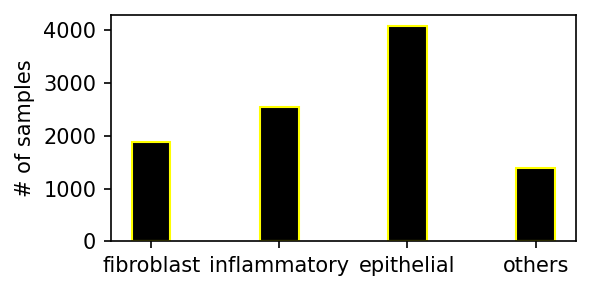

In [31]:
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([0,1,2,3], [(y==0).sum(), (y==1).sum(), (y==2).sum(), (y==3).sum()], color="black", edgecolor="yellow", width=0.3, align="center"); #plot a bar chart of the label frequency
plt.xticks([0,1,2,3],["fibroblast".format((y==0).sum()),"inflammatory".format((y==1).sum()), "epithelial".format((y==2).sum()), "others".format((y==3).sum())]);
plt.ylabel("# of samples")

#### OBSERVATIONS
It is observed from the bar graph that there seems to be a class imbalance based on the cell types, with around 1888 samples for fibroblast cell type, around 2543 samples with inflammatory cell types, around 4079 samples with epithelial cell types and around 1386 samples for other cell types. Thus, around 19% of all images are of fibroblast cell type, around 25.69% of all images are of inflammatory cell type, around 41.21% of all images are of epithelial cell type and around 14% of all images are of other samples.  

We'll now split the data into 4 different samples belonging to each cell type to get an idea what makes the classes unique. Such an analysis can often provide insight into possible feature engineering possibilities or which data transformations may be useful.

In [32]:
fibro_samples = X1[y == 0]
inflam_samples = X1[y == 1]
epithelial_samples = X1[y == 2]
other_samples = X1[y == 3]

#### LET'S NOW CREATE HISTOGRAMS FOR EACH CELL TYPE BASED ON DIFFERENT RGB VALUES

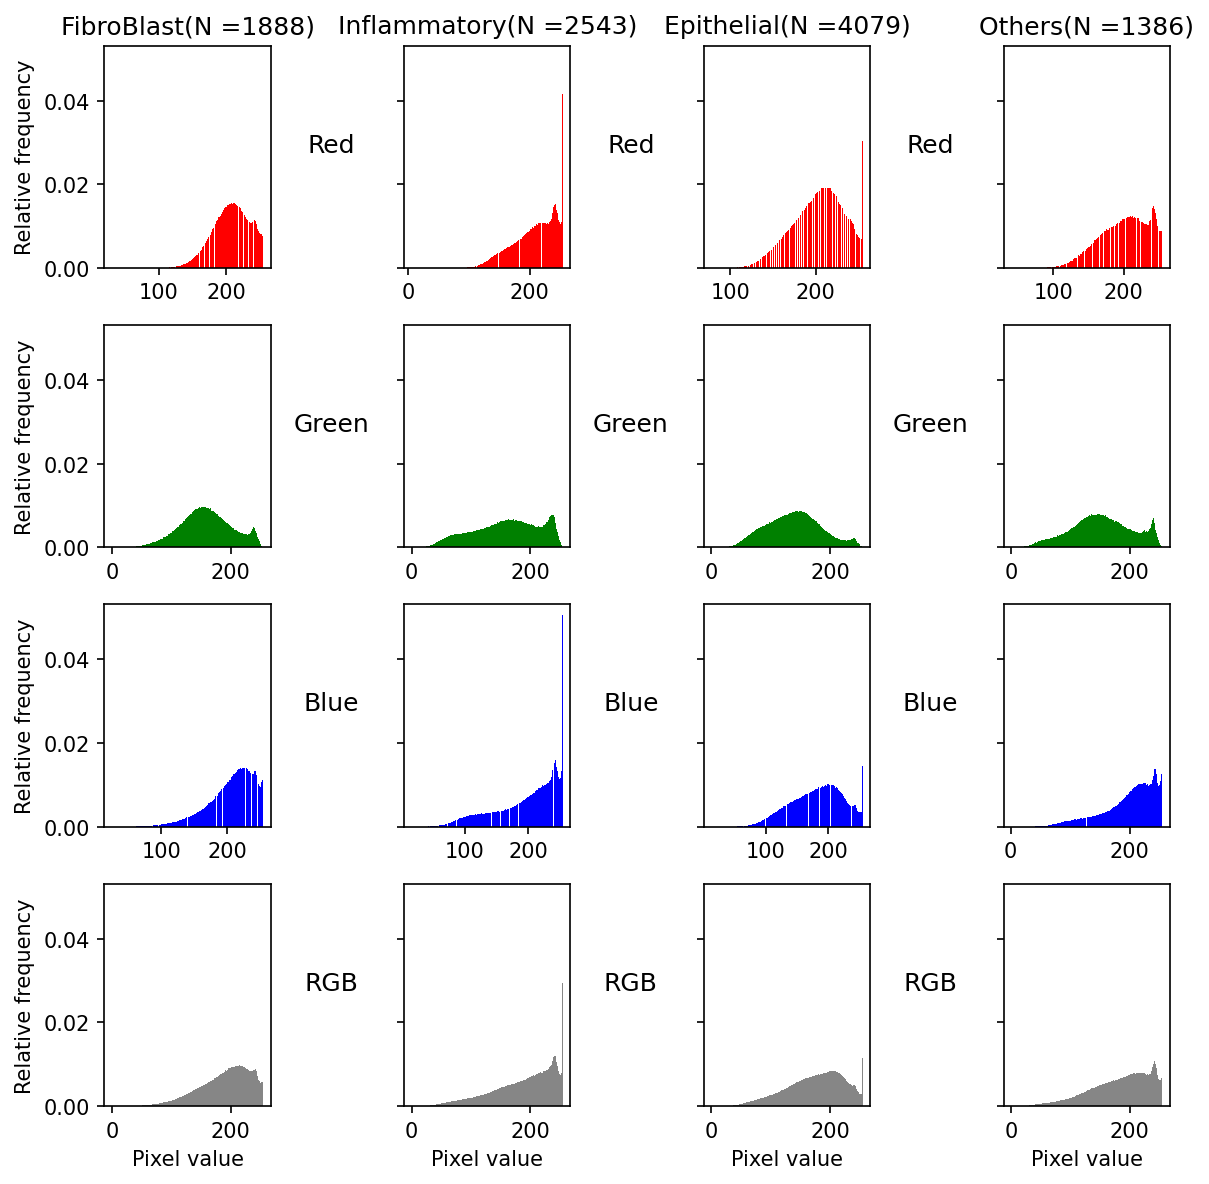

In [33]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,4,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(fibro_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True, color="red")
axs[0,1].hist(inflam_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True, color="red")
axs[0,2].hist(epithelial_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True, color="red")
axs[0,3].hist(other_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True, color="red")

axs[1,0].hist(fibro_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True, color="green")
axs[1,1].hist(inflam_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True, color="green")
axs[1,2].hist(epithelial_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True, color="green")
axs[1,3].hist(other_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True, color="green")

axs[2,0].hist(fibro_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True, color="blue")
axs[2,1].hist(inflam_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True, color="blue")
axs[2,2].hist(epithelial_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True, color="blue")
axs[2,3].hist(other_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True, color="blue")

#All channels
axs[3,0].hist(fibro_samples.flatten(),bins=nr_of_bins,density=True, color="#0f0f0f80")
axs[3,1].hist(inflam_samples.flatten(),bins=nr_of_bins,density=True, color="#0f0f0f80")
axs[3,2].hist(epithelial_samples.flatten(),bins=nr_of_bins,density=True, color="#0f0f0f80")
axs[3,3].hist(other_samples.flatten(),bins=nr_of_bins,density=True, color="#0f0f0f80")

#Set image labels
axs[0,0].set_title("FibroBlast(N =" + str(fibro_samples.shape[0]) + ")");
axs[0,1].set_title("Inflammatory(N =" + str(inflam_samples.shape[0]) + ")");
axs[0,2].set_title("Epithelial(N =" + str(epithelial_samples.shape[0]) + ")");
axs[0,3].set_title("Others(N =" + str(other_samples.shape[0]) + ")");


axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[0,2].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[0,3].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,2].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,3].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,2].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,3].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,2].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,3].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)

for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
axs[3,2].set_xlabel("Pixel value")
axs[3,3].set_xlabel("Pixel value")
fig.tight_layout()

#### OBSERVATIONS 
1. Samples belonging to inflammatory cell types have a higher or brighter pixel values specifically in the blue color channel
2. Samples belonging to epithelial cell types are most distributed in the red colour channel as compared to other cell types
3. All of the samples belonging to these cell types have higher distribution of red colour as compared to green, thus brighter red colour is observed as compared to green in all the samples.
4. For samples like inflammatory and epithelial, a higher frequency of pixel value around 255 is observed. They could be used to infer the presence of bright image regions in such cells.
5. Green colour is leastly distributed in all such samples as compared to other colours

#### LET'S HAVE A LOOK AT THE DISTRIBUTION OF MEAN BRIGHTNESS FOR ALL FOUR SAMPLES

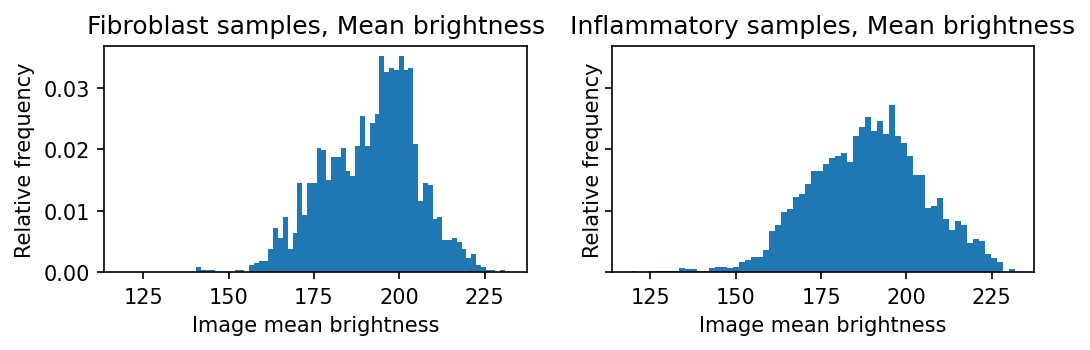

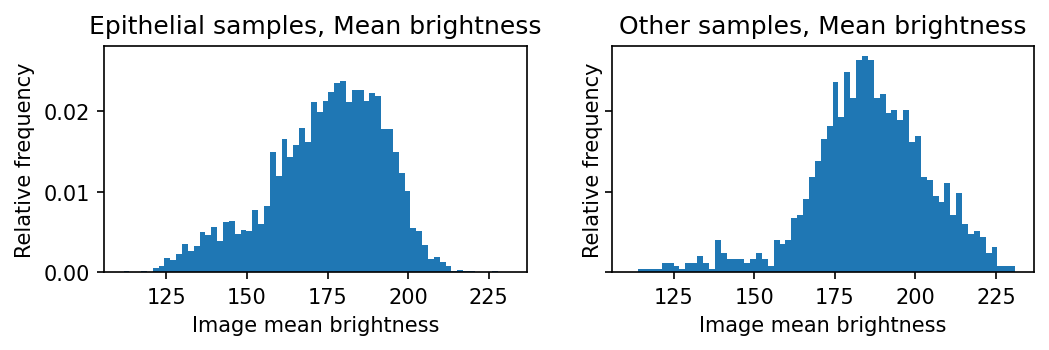

In [34]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(fibro_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(inflam_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
# axs[0].hist(np.mean(epithelial_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
# axs[1].hist(np.mean(other_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);

axs[0].set_title("Fibroblast samples, Mean brightness");
axs[1].set_title("Inflammatory samples, Mean brightness");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");


nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(epithelial_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(other_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);

axs[0].set_title("Epithelial samples, Mean brightness");
axs[1].set_title("Other samples, Mean brightness");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

#### OBSERVATIONS

1. From the histograms plotted above, it is observed that fibroblast, inflammatory and epithelial samples mostly follow a normal distribution wheras other samples are a bit skewed towards rights.
2. Fibroblast and inflammatory samples observe a peek value around 185-200 though the peak observed in fibroblast cells is much higher to that of inflammatory cells.
3. It is also observed from the plots that fibroblast, inflammatory and other samples are slightly more brighter than the epithelial samples because of the range of mean brightness observed along with higher peaks observed in all three cell types.

### EDA CONCLUSION
There are some easily spotted differences in the distributions of pixel values and mean image brightness between positive and negative samples. This is good, because whatever model we will use can likely use this.
Some of the images seem to contain very bright regions, like cells with inflammatory cell types are much brighter as compared to other samples which are likely artifacts of the recording process. We might have to find a way to deal with them. 

# MODEL DEVELOPMENT

A typical ML model development process consists of 4 steps, which are as following:

1. Determine your goals / Set up performance (evaluation) metric: Performance metric and target value. Problem dependent.

2. Setup the experiment: Setup the test/validation data, visualisers and debuggers needed to determine bottlenecks in performance (overfitting/under-fitting, feature importance).

3. Default Baseline Model: Identify the components of end-to-end pipeline including - Baseline Models, cost functions, optimisation.

4. Make incremental changes: Repeatedly make incremental changes such as gathering new data, adjusting hyper-parameters, or changing algorithms, based on specific findings from your instrumentation

### PERFORMANCE EVALUATION METRICS

Given the dataset provided as slightly imbalanced classes, it's quite easy to get a high accuracy score without actually making usefull predictions. Thus, accuracy score can only make sense only if the class labels are distributed normally. So, in case of our dataset, where slight class imbalance is observed, confusion matrix could be use to summarize the performance for our algorithms, as we can directly use our confusion matrix to determine precision or recall score. Precision is a measure about the ability of our model to identify only relevant data points and tell use about the proportion of actually correct positive identification whereas Recall is a measure about the ability of our model to find all relevant cases within the dataset and tell us about the proportion of how many actual positives were identified correctly. Another measure could be used is ROC AUC curve but given we are working with multi class classification it isn't a suitable fit as it is more accurate for binary classification. The average recall score of the model uses weighted average as both weighted and micro average are least affected by class imbalance though we would be using recall score for each cell type for our comparisons. Thus, using the recall score to determine the percentage of correctly predicted cell type is most suitable in this case. 

What data should we use to evaluate the performance?

We can generate "simulated" unseen data in several methods

CNN ( Convolutional neural networks )
RNN ( Recurrent neural networks )
ANN ( Artificial neural networks )
We will implement CNN technique to build our Machine Learning models and analyse their performance.

This is a user built method to sort the images in ascending order

In [3]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

The function is built to normalize the inputs for training data for zero mean and unit variance

In [4]:
def normalize(X_train,X_test):
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    return X_train, X_test

### Defining Machine Learning Models
CNN : A CNN is a class of deep neural networks which is most commonly used to analyze viual imagery. CNN uses a special technique called Convolution instead of matriix multiiplications. CNN are composed of multiple layers of artifical neurons. When we input an image in a ConvNet, each layer generates several activation functions that are passed on to the next layer.The first layer usually extracts basic features such as horizontal or diagonal edges. This output is passed on to the next layer which detects more complex features such as corners or combinational edges. As we move deeper into the network it can identify even more complex features such as objects, faces, etc.

CNN is used for image classification and recognition because of its high accuracy and they are preferred for spatial data such as images compared to RNN which is suitable for temporal data, also called sequential data. ANN is one of the considered technique as well but image classification using ANN gets very difficult as 2 dimensional images Needs to be converted to 1 dimensional vectors, this increases the number of trainable parameters exponentially.

### CNN Single Fully Connected Layer model : Baseline Model

This model takes in input images of size (32,32,3). A model with a single FC layer was trained such that a large 256 unit layer followed by the final layer uses the softmax activation function that is used to get the probabilities for each of the 4 classes corresponding to the four cell types.  Finally, the probabilities of the cell type in the images belonging to different cell types is attained and thus helping us in labelling the input images with different cell types

In [5]:
#A baseline CNN model with single fully connected layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



model = Sequential()

model_transfer_learning = tf.keras.Sequential()

model_transfer_learning.add(layers.Flatten())
model_transfer_learning.add(layers.Dense(256, activation='relu'))
model_transfer_learning.add(layers.Dense(4, activation='softmax'))


Certain training parameters like maximum epochs and batch size is used. Apart from that a learning decay is used, initially starting at 0.1 which is further dropped after every 20 epochs

In [6]:
#training parameters
batch_size = 128
maxepoches = 150
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

Next up, the path of the cell images is defined which will vary with the systems being used

In [7]:
#The path of the cell images 
#This will vary with the system being used
PATH = "./Image_classification_data/patch_images/"
data_path = PATH

The next step would be to sort the patched images and add them to a local variable which will act like a list of all the data images

In [8]:
#sorts the images and adds the sorted values in a list
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png', '100.png', '101.png', '102.png', '103.png', '104

It is followed by adding the correct path to the images and loading such images. Given the images would be in 2 dimension, theyy are to be converted to 4D by expanding the dimensions

In [9]:
img_data_list = []

#Add the correct path to images and load the images
#As the loaded images would be in 2 dimension, convert it to 4 dimension by expanding the dimensions across axis 0
#Make sure the shape of images is crrect, that is 4 dimensional
for dataset in sorted_alphanumeric(data_dir_list):
    print(dataset)
    img_path = data_path + '/' + dataset
    img = image.load_img(img_path, target_size=(32,32))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #     x = x/255
    print('Input image shape:', x.shape)
    img_data_list.append(x)

1.png
Input image shape: (1, 32, 32, 3)
2.png
Input image shape: (1, 32, 32, 3)
3.png
Input image shape: (1, 32, 32, 3)
4.png
Input image shape: (1, 32, 32, 3)
5.png
Input image shape: (1, 32, 32, 3)
6.png
Input image shape: (1, 32, 32, 3)
7.png
Input image shape: (1, 32, 32, 3)
8.png
Input image shape: (1, 32, 32, 3)
9.png
Input image shape: (1, 32, 32, 3)
10.png
Input image shape: (1, 32, 32, 3)
11.png
Input image shape: (1, 32, 32, 3)
14.png
Input image shape: (1, 32, 32, 3)
15.png
Input image shape: (1, 32, 32, 3)
16.png
Input image shape: (1, 32, 32, 3)
17.png
Input image shape: (1, 32, 32, 3)
18.png
Input image shape: (1, 32, 32, 3)
19.png
Input image shape: (1, 32, 32, 3)
20.png
Input image shape: (1, 32, 32, 3)
21.png
Input image shape: (1, 32, 32, 3)
22.png
Input image shape: (1, 32, 32, 3)
23.png
Input image shape: (1, 32, 32, 3)
24.png
Input image shape: (1, 32, 32, 3)
25.png
Input image shape: (1, 32, 32, 3)
26.png
Input image shape: (1, 32, 32, 3)
27.png
Input image shape:

In [10]:
#Convert the images list to a numpy array and roll the axis backward (as start value is less than axis value)
img_data = np.array(img_data_list)
#Confirm the shape of the images
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)
#Get the num of samples to be used for classification
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)

(20280, 1, 32, 32, 3)
(1, 20280, 32, 32, 3)
(20280, 32, 32, 3)
sample 20280


From the EDA, we were able to calculate the distribution of the images based on the cell types. Thus, a new numpy array will be created that contains the labelled marked as 0,1,2 or 3 based on the distribution of the images 

In [11]:
#Initilaize an array of all ones for the number of smaples and update the lables as required

labels = np.ones((num_of_samples,), dtype='int64')
labels[0:4080] = 0
labels[4080:5969] = 1
labels[5969:8513] = 2
labels[8513:] = 3

The labels list is then converted to a matrix with num_classes ranging from 0 to 3(total 4 classes)

In [12]:
#A list of labels is used to differentiate values in labels list
names = ['epithelial', 'fibroblast', 'inflammatory', 'others']
num_classes = 4
#The labels list is then converted to a matrix with num_classes ranging from 0 to 3(total 4 classes)
Y = np_utils.to_categorical(labels, num_classes)

Train Test Split is used to split the training and testing data
We decide the proportions according to the size and type of the data avaiable to use. A general rule is that if the dataset is between 100 to 10,00,000 then we split it in the ration 80:20, where 80% percent is training set and 20% is test set. 


#### Note : 
If we use all our data as a training set then there is a chance the model will memorize the trends in the training data, thus causing the model to "overfit".

If the test dataset isn't randomised or is too small, then we might not be able to truly analyse our model's prediction capability.

In [13]:
#Training Data: The subset we will use to build our model
#Test Data: The subset we will use to evaluate the performance of the developed model.
x_train, x_test, y_train, y_test = train_test_split(img_data, Y, test_size=0.2, random_state=2)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

The next technique is used to normalize the sample such that unit variance along with 0 mean is achieved

In [14]:
#Normalize the sample
x_train, x_test = normalize(x_train, x_test)

Now, we would be defining the callbacks for our model. 
We decided to define a LearningRateScheduler that at the beginning of every epoch, it gets the updated learning rate value from the function with the current epoch and the current elarning rate is then applied to update the learning rate on the optimizer

The custom scheduler reduces the learning rate by half for each epoch drop, which is equal to 20

In [15]:
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))

In [16]:
#Callbacks to be used while training the model
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
#We decided against using earlystopping ffor this model because the val_loss determined for the first 0 epochs is quite random, and the model will stop training early is ES is used provioing us with unstable model. Whereas, if the model is left to runn for all 150 epochs, patterns are observed and loss decreases uniformly thus providing a better overall model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)

Now, an augmented image generator is used that generated batches of images data with real time augmentation.
The generator rotates the images in random order at a degree of 0 to 180 and hence shifts the images horizontally and vertically in random order before flip some of the images

In [17]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=True)  

datagen.fit(x_train)

SGD optimizer which a varient of Gradient Descent is used. The optimizer will try to update the model parameter more frequenctly hence providing converging in less time. The memory used would be less and it is not required to store any loss functions.

In [18]:
#optimization details
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model_transfer_learning.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

/home/kaushal/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
import time
start_time = time.time()
history = model_transfer_learning.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=maxepoches,
                            validation_data=(x_test, y_test),callbacks=[reduce_lr],verbose=2)

/home/kaushal/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
126/126 - 10s - loss: 2.0680 - accuracy: 0.3840 - val_loss: 1.2599 - val_accuracy: 0.4019
Epoch 2/150
126/126 - 9s - loss: 1.0955 - accuracy: 0.4391 - val_loss: 1.1063 - val_accuracy: 0.3688
Epoch 3/150
126/126 - 9s - loss: 1.0933 - accuracy: 0.4121 - val_loss: 1.0655 - val_accuracy: 0.4236
Epoch 4/150
126/126 - 9s - loss: 1.0680 - accuracy: 0.4642 - val_loss: 1.0987 - val_accuracy: 0.3824
Epoch 5/150
126/126 - 9s - loss: 1.0901 - accuracy: 0.4097 - val_loss: 1.0882 - val_accuracy: 0.3940
Epoch 6/150
126/126 - 9s - loss: 1.0780 - accuracy: 0.4400 - val_loss: 1.0898 - val_accuracy: 0.3905
Epoch 7/150
126/126 - 9s - loss: 1.0845 - accuracy: 0.4129 - val_loss: 1.0761 - val_accuracy: 0.4492
Epoch 8/150
126/126 - 10s - loss: 1.0731 - accuracy: 0.4437 - val_loss: 1.0597 - val_accuracy: 0.4307
Epoch 9/150
126/126 - 9s - loss: 1.0678 - accuracy: 0.4571 - val_loss: 1.0612 - val_accuracy: 0.4287
Epoch 10/150
126/126 - 9s - loss: 1.0884 - accuracy: 0.4241 - val_loss: 1.1279 - val_accu

In [20]:
print('Max Test accuracy:', max(history.history['val_accuracy']))
scores = model_transfer_learning.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Max Test accuracy: 0.564595639705658
127/127 [==============================] - 1s 4ms/step - loss: 0.9039 - accuracy: 0.5611
Test loss: 0.9038692712783813
Test accuracy: 0.5611439943313599


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


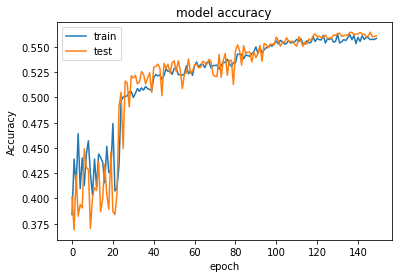

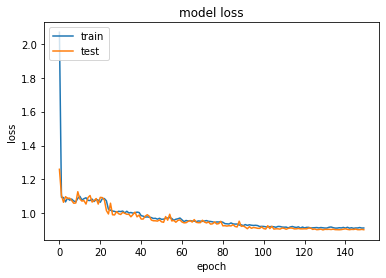

In [21]:
import matplotlib.pyplot as plt
# visualizing losses and accuracy
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
predicted_x_base = model_transfer_learning.predict(x_test)

In [24]:
from sklearn.metrics import confusion_matrix
import pandas as pd


cat_y_labels = pd.DataFrame(y_test).idxmax(axis=1)
cat_predict = pd.DataFrame(predicted_x_base).idxmax(axis=1)

confusion_matrix(cat_y_labels, cat_predict)

array([[1077,   88,  332,    0],
       [ 724,  103,  310,    0],
       [ 273,   44, 1096,    0],
       [   3,    1,    5,    0]])

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Accuracy score: ", accuracy_score(cat_y_labels, cat_predict))
final_precision = precision_score(cat_y_labels, cat_predict, average='weighted')
print('Precision: %f' %final_precision)
final_recall = recall_score(cat_y_labels, cat_predict, average='weighted')
print('Recall: %f' %final_recall)
final_f1 = f1_score(cat_y_labels, cat_predict, average='weighted')
print('F1 Score: %f' %final_f1)

Accuracy score:  0.5611439842209073
Precision: 0.532785
Recall: 0.561144
F1 Score: 0.506462


/home/kaushal/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As recall would be used to determine the percentage of correctly identified cell types, recall for a given cell type will be given by, Recall = TP / (TP+FP. )

Recall_Fibro = TP(epithelial, class: 0)/ (FP(class:1,2,3) + TP(epithelial, class: 0))

In [61]:
Recall_Epi = 1077/(1077+724+273+3)
Recall_Fibro = 103/(88+103+44+1)
Recall_Inflam = 1096/(332+310+1096+5)
Recall_other = 0

print("Recall for epithelial cell-type:      %f" %Recall_Epi)
print("Recall for fibroblast cell-type:      %f" %Recall_Fibro)
print("Recall for inflammatory cell-type:    %f" %Recall_Inflam)
print("Recall for other cell-type:           %f" %Recall_other)

Recall for epithelial cell-type:      0.518536
Recall for fibroblast cell-type:      0.436441
Recall for inflammatory cell-type:    0.628801
Recall for other cell-type:           0.000000


#### Conclusion :
It is derived from the confusion matrix that a recall of 0.51 was calculated for predicting epithelial cell type, that is 51% of the epithelial cells were correctly predicted. Also, the recall for predicting fibroblast cell types is 0.43, that is 43% of the fibroblast cell types were correctly predicted. Inflammatory cell types had the highest recall with 0.62 stating 62% of the inflammatory cell types were correctly predicted whereas the model did worse in predicting other samples with a recall of 0.


### CNN Model with 7 trainable layer And Image Augmentation

User built function to determine the f1 score to be used when the model is fitted against the training data

In [28]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Train Test Split is used to split the training and testing data We decide the proportions according to the size and type of the data avaiable to use. A general rule is that if the dataset is between 100 to 10,00,000 then we split it in the ration 80:20, where 80% percent is training set and 20% is test set.

#### Note :
If we use all our data as a training set then there is a chance the model will memorize the trends in the training data, thus causing the model to "overfit".

If the test dataset isn't randomised or is too small, then we might not be able to truly analyse our model's prediction capability.

In [30]:
from sklearn.utils import shuffle
Y = np_utils.to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

This model takes in input images of size (32,3,3). The given model has seven trainable layers, the first part having two convolutional layers followed by a pooling layer with pool size (2,2) such that dimension is reduced by half. The second part again consists of two convolutional layer followed by with similar configuration followed by a similar pooling layer. Zero padding with 1 pixel is done in first Conv layer with stride being set to 1 for both Conv layer in first part. The pooling layer used is provided with stride 2 and without padding whereas the other conv layers use similar configuration as earlier. All the there fully connected layer takes input as 512 dimensional vector and the final fully connected layer uses the softmax activation function that is used to get the probabilities for each of the 4 classes corresponding to the four cell types. To prevent over fitting, drop out is used after each Rectifier along with Batch Normalization

In [31]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32,32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 64)       

Now, we would be defining the callbacks for our model. We decided to define a LearningRateScheduler that at the beginning of every epoch, it gets the updated learning rate value from the function with the current epoch and the current elarning rate is then applied to update the learning rate on the optimizer. Apart from that CSVLogger is used that saves the loss and f1 values determined during training in a dummy csv file

In [39]:
from keras.callbacks import CSVLogger
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-15)

#Saves the f1 score and val_f1 along with losses in a dummy csv
csv_logger = CSVLogger('./Image_classification_data//CNN_F1_Score_Dummy.csv', append=True, separator=",")

#Uses Adam optimisizer
#Still needs debugging
adam = Adam(lr=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.0e-6,amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[f1])

/home/kaushal/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Now, an augmented image generator is used that generated batches of images data with real time augmentation.
The generator randomly flips the images on both vertical and horizontal axis

In [40]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(x_train)

In [41]:
batch_size =64
epochs = 60

In [42]:
history_model_2 = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test),
                                  callbacks=[lr_reducer, csv_logger])

/home/kaushal/.local/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/60
254/254 [==============================] - 109s 346ms/step - loss: 1.3784 - f1: 0.4321 - val_loss: 1.9090 - val_f1: 0.3957
Epoch 2/60
254/254 [==============================] - 85s 334ms/step - loss: 0.9330 - f1: 0.5394 - val_loss: 27.9740 - val_f1: 0.3240
Epoch 3/60
254/254 [==============================] - 85s 335ms/step - loss: 0.8724 - f1: 0.5699 - val_loss: 53.0110 - val_f1: 0.3240
Epoch 4/60
254/254 [==============================] - 85s 334ms/step - loss: 0.8376 - f1: 0.5752 - val_loss: 74.3423 - val_f1: 0.3240
Epoch 5/60
254/254 [==============================] - 85s 334ms/step - loss: 0.8059 - f1: 0.6019 - val_loss: 14.2814 - val_f1: 0.2789
Epoch 6/60
254/254 [==============================] - 85s 333ms/step - loss: 0.7857 - f1: 0.6155 - val_loss: 26.3480 - val_f1: 0.3944
Epoch 7/60
254/254 [==============================] - 85s 334ms/step - loss: 0.7764 - f1: 0.6194 - val_loss: 20.2064 - val_f1: 0.3240
Epoch 8/60
254/254 [==============================] - 85s 333m

dict_keys(['loss', 'f1', 'val_loss', 'val_f1', 'lr'])


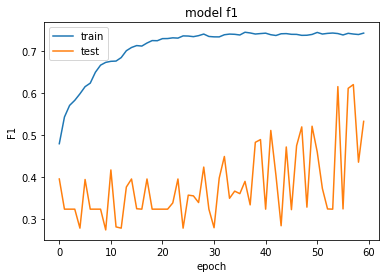

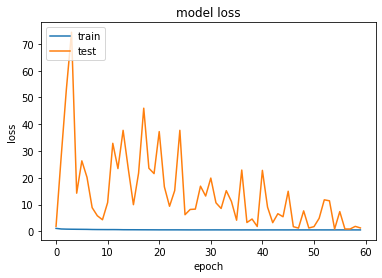

In [46]:
# # visualizing losses and accuracy
print(history_model_2.history.keys())
# # summarize history for accuracy
plt.plot(history_model_2.history['f1'])
plt.plot(history_model_2.history['val_f1'])
plt.title('model f1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_model_2.history['loss'])
plt.plot(history_model_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
print('Max Test f1:', max(history_model_2.history['val_f1']))
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test f1:', scores[1])

Max Test f1: 0.620015561580658
127/127 [==============================] - 5s 42ms/step - loss: 1.3116 - f1: 0.5326
Test loss: 1.3115973472595215
Test f1: 0.5325989127159119


In [60]:
predicted_x_model_2 = model.predict(x_test)

In [61]:
from sklearn.metrics import confusion_matrix
import pandas as pd


cat_y_labels_model2 = pd.DataFrame(y_test).idxmax(axis=1)
cat_predict_model2 = pd.DataFrame(predicted_x_model_2).idxmax(axis=1)

confusion_matrix(cat_y_labels_model2, cat_predict_model2)

array([[ 778,  159,  667,    1],
       [ 366,  218,  547,    0],
       [  57,   31, 1225,    1],
       [   0,    0,    6,    0]])

In [66]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer


def multi_class_roc_auc_score(truth, pred, average="micro"):
    
    lb=LabelBinarizer()
    lb.fit(truth)
    
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    
    return roc_auc_score(truth, pred, average=average)

In [68]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Accuracy score: ", accuracy_score(cat_y_labels_model2, cat_predict_model2))
final_precision_model2 = precision_score(cat_y_labels_model2, cat_predict_model2, average='weighted')
print('Precision: %f' %final_precision_model2)
final_recall_model2 = recall_score(cat_y_labels_model2, cat_predict_model2, average='weighted')
print('Recall: %f' %final_recall_model2)
final_f1_model2 = f1_score(cat_y_labels_model2, cat_predict_model2, average='weighted')
print('F1 Score: %f' %final_f1_model2)
final_roc_model2 = multi_class_roc_auc_score(cat_y_labels_model2,cat_predict_model2)
print('ROC AUC Score: %f' %final_roc_model2)

Accuracy score:  0.5475838264299803
Precision: 0.567643
Recall: 0.547584
F1 Score: 0.509579
ROC AUC Score: 0.698389


As recall would be used to determine the percentage of correctly identified cell types, recall for a given cell type will be given by, Recall = TP / (TP+FP. )

Recall_Fibro = TP(epithelial, class: 0)/ (FP(class:1,2,3) + TP(epithelial, class: 0))

In [62]:
Recall_Epi_model2 = 778/(778+366+57+0)
Recall_Fibro_model2 = 218/(159+218+31+0)
Recall_Inflam_model2 = 1225/(667+547+1225+6)
Recall_other_model2 = 0/(1+0+1+0)

print("Recall for epithelial cell-type:      %f" %Recall_Epi_model2)
print("Recall for fibroblast cell-type:      %f" %Recall_Fibro_model2)
print("Recall for inflammatory cell-type:    %f" %Recall_Inflam_model2)
print("Recall for other cell-type:           %f" %Recall_other_model2)

Recall for epithelial cell-type:      0.647794
Recall for fibroblast cell-type:      0.534314
Recall for inflammatory cell-type:    0.501022
Recall for other cell-type:           0.000000


#### CONCLUSION :
It is derived from the confusion matrix that a recall of 0.64, predicting 64% of the epithelial cell types were correctly predicted. As compared to the previous model, an improvement of 13% is observed to predict epithelial cell type. Also, 53% of the fibroblast cell types were correctly predicted given recall of 0.53 is observed. Though, the model underperformed for predicting inflammatory cell types with recall 0.50 as compared to the earlier model whereas the model did worse in predicting other samples with a recall of 0. Given the difference between validation f1 and trained f1 score, the model seems to overfit a bit.


#### CNN Model with 14 trainable layers on Stained Images And Image Augmentation

During the EDA, some of the images seem to contain very bright regions, which are likely artifacts of the recording process. Due to the same reason, we plan to use stain normalization. 
Stain normalization is an important processing task for computer-aided diagnosis (CAD) systems in modern digital pathology expecially when dealing with Histopathologic Cells. This task reduces the color and intensity variations present in stained images from different laboratories.

Color variation is a problem in histopathology based on light microscopy due to multiple reasons which can range from ussing different scanners, variable chemical from different manufactures of stains. The coloring can also depend on different staining procedures, timing, concentration etc. These factors cause color variation in histopathology, Hence the use of Stain Normalization is important to reduce the color variation between all samples. (1) (PDF) A Non-Linear Mapping Approach to Stain Normalisation in Digital Histopathology Images using Image-Speciﬁc Colour Deconvolution. Available from: https://www.researchgate.net/publication/260288815_A_Non-Linear_Mapping_Approach_to_Stain_Normalisation_in_Digital_Histopathology_Images_using_Image-Specific_Colour_Deconvolution [accessed May 19 2021].

Report Example:

Stain normalization has increased accuracy, precision, recall, and f-score values by ap-proximately 10%, as shown in Table7.These results indicate that the stain normaliza-tion step is an effective pre-processing part which can mitigate high staining intensityvariance between histology samples

(1) (PDF) Deep Learning Model for Cell Nuclei Segmentation and Lymphocyte Identification in Whole Slide Histology Images. Available from: https://www.researchgate.net/publication/348411519_Deep_Learning_Model_for_Cell_Nuclei_Segmentation_and_Lymphocyte_Identification_in_Whole_Slide_Histology_Images [accessed May 19 2021].

In [ ]:
# Stain normalizating all the images and saving them to a new directory " transformed_images"
# As the images were already normalized by us earlier, this won't be ran in the submission notebook
count = 0
for l in range(1753,df.shape[0]):

    path = df['path'][l]

    if str(path) != "./Image_classification_data/patch_images/1.png":
        print(str(path))
        to_transform = staintools.read_image(path)
        target = staintools.LuminosityStandardizer.standardize(target)
        to_transform = staintools.LuminosityStandardizer.standardize(to_transform)
        normalizer = staintools.StainNormalizer(method='vahadane')
        normalizer.fit(target)
        transformed = normalizer.transform(to_transform)
        new_path = './Image_classification_data/transformed_images/'+ str(df['ImageName'][l])
        cv2.imwrite(str(new_path), transformed.astype(np.uint8))
        count += 1

    

In [ ]:
new_path = './Image_classification_data/transformed_images/1.png'
cv2.imwrite(str(new_path), target.astype(np.uint8))

##### Creating dataframe with transformed images

In [ ]:
path = "./Image_classification_data/" #adapt this path, when running locally
train_path = path + 'transformed_images/'

df_transformed = pd.DataFrame({'path': glob(os.path.join(train_path,'*.png'))}) # load the filenames
print(df_transformed)

df_transformed['InstanceID'] = df_transformed.path.map(lambda x: int(x.split('/')[3].split(".")[0]))
print(df_transformed.dtypes)
labels = pd.read_csv(path+"data_labels_mainData.csv") # read the provided labels
print(labels.dtypes)

df_transformed = pd.merge(df_transformed, labels, on='InstanceID', how='right')


df_transformed.head(3)



In [ ]:
print(df_transformed['path'].duplicated().any())
print(df_transformed['InstanceID'].duplicated().any())

In [ ]:
df_transformed.count()

In [1]:
from __future__ import print_function
import keras
from keras.utils import np_utils

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
from sklearn.model_selection import train_test_split
import numpy as np
import re
import os
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
from sklearn.metrics import confusion_matrix
import time
start_time = 0
global_scores = []


Using TensorFlow backend.


In [2]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)


In [3]:
#The function is built to normalize the inputs for training data for zero mean and unit variance
def normalize(X_train,X_test):
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    return X_train, X_test

A similar architecture as above model was used , except that the conventional layers were increased from 4 to 13 and FC Layers were reduced from 3 to 1. The model was trained over stained images as talked earlier and recorded a  major difference  in terms of training time as more layers were used to build the model, which took upto 15 hours for training. 

In [4]:
model = Sequential()
weight_decay = 0.0005

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3),
                         kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(4))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)       

In [5]:
batch_size = 128
#maxepoches = 250
maxepoches = 50
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

In [6]:
PATH = "./Image_classification_data/transformed_images/"
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png', '100.png', '101.png', '102.png', '103.png', '104

In [7]:
img_data_list = []

for dataset in sorted_alphanumeric(data_dir_list):
    print(dataset)
    img_path = data_path + '/' + dataset
    img = image.load_img(img_path, target_size=(32,32))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #     x = x/255
    print('Input image shape:', x.shape)
    img_data_list.append(x)

1.png
Input image shape: (1, 32, 32, 3)
2.png
Input image shape: (1, 32, 32, 3)
3.png
Input image shape: (1, 32, 32, 3)
4.png
Input image shape: (1, 32, 32, 3)
5.png
Input image shape: (1, 32, 32, 3)
6.png
Input image shape: (1, 32, 32, 3)
7.png
Input image shape: (1, 32, 32, 3)
8.png
Input image shape: (1, 32, 32, 3)
9.png
Input image shape: (1, 32, 32, 3)
10.png
Input image shape: (1, 32, 32, 3)
11.png
Input image shape: (1, 32, 32, 3)
14.png
Input image shape: (1, 32, 32, 3)
15.png
Input image shape: (1, 32, 32, 3)
16.png
Input image shape: (1, 32, 32, 3)
17.png
Input image shape: (1, 32, 32, 3)
18.png
Input image shape: (1, 32, 32, 3)
19.png
Input image shape: (1, 32, 32, 3)
20.png
Input image shape: (1, 32, 32, 3)
21.png
Input image shape: (1, 32, 32, 3)
22.png
Input image shape: (1, 32, 32, 3)
23.png
Input image shape: (1, 32, 32, 3)
24.png
Input image shape: (1, 32, 32, 3)
25.png
Input image shape: (1, 32, 32, 3)
26.png
Input image shape: (1, 32, 32, 3)
27.png
Input image shape:

In [8]:
img_data = np.array(img_data_list)
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)

(20280, 1, 32, 32, 3)
(1, 20280, 32, 32, 3)
(20280, 32, 32, 3)
sample 20280


From the EDA, we were able to calculate the distribution of the images based on the cell types. Thus, a new numpy array will be created that contains the labelled marked as 0,1,2 or 3 based on the distribution of the images

In [9]:
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:4080] = 0
labels[4080:5969] = 1
labels[5969:8513] = 2
labels[8513:] = 3

The labels list is then converted to a matrix with num_classes ranging from 0 to 3(total 4 classes)

In [10]:
names = ['epithelial', 'fibroblast', 'inflammatory', 'others']
num_classes = 4
Y = np_utils.to_categorical(labels, num_classes)

Train Test Split is used to split the training and testing data We decide the proportions according to the size and type of the data avaiable to use. A general rule is that if the dataset is between 100 to 10,00,000 then we split it in the ration 80:20, where 80% percent is training set and 20% is test set.

##### Note :
If we use all our data as a training set then there is a chance the model will memorize the trends in the training data, thus causing the model to "overfit".

If the test dataset isn't randomised or is too small, then we might not be able to truly analyse our model's prediction capability.

In [11]:
x_train, x_test, y_train, y_test = train_test_split(img_data, Y, test_size=0.2, random_state=2)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#Normalize the sample
x_train, x_test = normalize(x_train, x_test)

Now, we would be defining the callbacks for our model. We decided to define a LearningRateScheduler that at the beginning of every epoch, it gets the updated learning rate value from the function with the current epoch and the current elarning rate is then applied to update the learning rate on the optimizer

The custom scheduler reduces the learning rate by half for each epoch drop, which is equal to 20

In [12]:
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))

In [13]:
#Callbacks to be used while training the model
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)

Now, an augmented image generator is used that generated batches of images data with real time augmentation. The generator rotates the images in random order at a degree of 0 to 180 and hence shifts the images horizontally and vertically in random order before flip some of the images

In [14]:
 #data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=True)  

datagen.fit(x_train)

SGD optimizer which a varient of Gradient Descent is used. The optimizer will try to update the model parameter more frequenctly hence providing converging in less time. The memory used would be less and it is not required to store any loss functions.

In [15]:
#optimization details
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

In [16]:
import time
start_time = time.time()
history_stained = model.fit_generator(datagen.flow(x_train, y_train,
                            batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=maxepoches,
                validation_data=(x_test, y_test),callbacks=[reduce_lr],verbose=2)

Epoch 1/50
 - 752s - loss: 30.9044 - accuracy: 0.3459 - val_loss: 559.8014 - val_accuracy: 0.2821
Epoch 2/50
 - 704s - loss: 25.1914 - accuracy: 0.3551 - val_loss: 21.9817 - val_accuracy: 0.3679
Epoch 3/50
 - 702s - loss: 19.5267 - accuracy: 0.3915 - val_loss: 17.2775 - val_accuracy: 0.3484
Epoch 4/50
 - 717s - loss: 15.3331 - accuracy: 0.4482 - val_loss: 13.6328 - val_accuracy: 0.3489
Epoch 5/50
 - 788s - loss: 12.1039 - accuracy: 0.4783 - val_loss: 10.9436 - val_accuracy: 0.3484
Epoch 6/50
 - 778s - loss: 9.6049 - accuracy: 0.4949 - val_loss: 8.6904 - val_accuracy: 0.3486
Epoch 7/50
 - 763s - loss: 7.6631 - accuracy: 0.4967 - val_loss: 7.0829 - val_accuracy: 0.3481
Epoch 8/50
 - 722s - loss: 6.1656 - accuracy: 0.5047 - val_loss: 5.8185 - val_accuracy: 0.3481
Epoch 9/50
 - 772s - loss: 5.0103 - accuracy: 0.5025 - val_loss: 4.7709 - val_accuracy: 0.2764
Epoch 10/50
 - 772s - loss: 4.1080 - accuracy: 0.5123 - val_loss: 4.0592 - val_accuracy: 0.3489
Epoch 11/50
 - 809s - loss: 3.4030 - a

In [17]:
print('Max Test accuracy:', max(history_stained.history['val_accuracy']))
scores = model.evaluate(x_test, y_test, verbose=1)
global_scores = scores
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Max Test accuracy: 0.5648422241210938
4056/4056 [==============================] - 58s 14ms/step
Test loss: 1.0646319135406312
Test accuracy: 0.5495561957359314


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


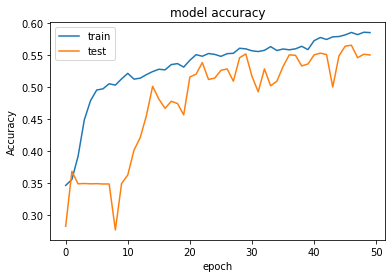

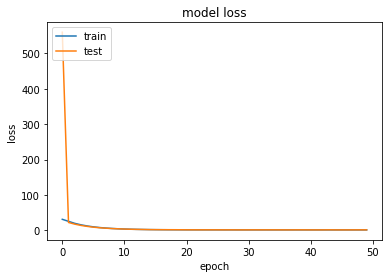

In [19]:
import matplotlib.pyplot as plt
        # # visualizing losses and accuracy
print(history_stained.history.keys())
        # # summarize history for accuracy
plt.plot(history_stained.history['accuracy'])
plt.plot(history_stained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_stained.history['loss'])
plt.plot(history_stained.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()                 


In [21]:
predicted_x_stained = model.predict(x_test)

In [23]:
from sklearn.metrics import confusion_matrix
import pandas as pd


cat_y_labels_stained = pd.DataFrame(y_test).idxmax(axis=1)
cat_predict_stained = pd.DataFrame(predicted_x_stained).idxmax(axis=1)

confusion_matrix(cat_y_labels_stained, cat_predict_stained)

array([[ 944,   76,  477,    0],
       [ 675,   88,  374,    0],
       [ 195,   21, 1197,    0],
       [   3,    0,    6,    0]], dtype=int64)

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer


def multi_class_roc_auc_score(truth, pred, average="micro"):
    
    lb=LabelBinarizer()
    lb.fit(truth)
    
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    
    return roc_auc_score(truth, pred, average=average)

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("Accuracy score: ", accuracy_score(cat_y_labels_stained, cat_predict_stained))
final_precision_stained = precision_score(cat_y_labels_stained, cat_predict_stained, average='weighted')
print('Precision: %f' %final_precision_stained)
final_recall_stained = recall_score(cat_y_labels_stained, cat_predict_stained, average='weighted')
print('Recall: %f' %final_recall_stained)
final_f1_stained = f1_score(cat_y_labels_stained, cat_predict_stained, average='weighted')
print('F1 Score: %f' %final_f1_stained)
final_roc_stained = multi_class_roc_auc_score(cat_y_labels_stained,cat_predict_stained)
print('ROC AUC Score: %f' %final_roc_stained)

Accuracy score:  0.5495562130177515
Precision: 0.528116
Recall: 0.549556
F1 Score: 0.488143
ROC AUC Score: 0.699704


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As recall would be used to determine the percentage of correctly identified cell types, recall for a given cell type will be given by, Recall = TP / (TP+FP. )

Recall_Epithelial = TP(epithelial, class: 0)/ (FP(class:1,2,3) + TP(epithelial, class: 0))

In [63]:
Recall_Epi_stained = 944/(944+675+195+3)
Recall_Fibro_stained = 88/(76+88+21+0)
Recall_Inflam_stained = 1197/(477+374+1197+6)
Recall_other_stained = 0

print("Recall for epithelial cell-type:      %f" %Recall_Epi_stained)
print("Recall for fibroblast cell-type:      %f" %Recall_Fibro_stained)
print("Recall for inflammatory cell-type:    %f" %Recall_Inflam_stained)
print("Recall for other cell-type:           %f" %Recall_other_stained)

Recall for epithelial cell-type:      0.519538
Recall for fibroblast cell-type:      0.475676
Recall for inflammatory cell-type:    0.582765
Recall for other cell-type:           0.000000


#### CONCLUSION :
The model was trained over stained images as talked earlier and recorded a  major difference  in terms of training time as more layers were used to build the model, which took upto 15 hours for training. Training the model on stained images and plotting confusion matrix helped in deriving that a recall of 0.51, predicting 51% of the epithelial cell types were correctly predicted. As compared to the base model no such difference is observed in predicting correct classification of epithelial cells though the model because of less epochs didn’t perform well as compared  to the model with 7 trainable layers. Apart from that, a recall of 0.47, predicting 47% of the fibroblast cell types correctly was observed, which is a slight improvement from our base model but didn’t perform well as compared  to the model with 7 trainable layers. The model predicted 58% of inflammatory cells correctly which is a 8% improvement from the model with 7 trainable layers but still underperformed as compared to the base model. The model did worse in predicting other samples with a recall of 0. Thus, it is concluded that stained images didn’t have much effect on the performance of the model but rather other hyper parameters like number of epochs and trainable layer certainly helped the model. So, the next model will be built by extending this model and using higher hyper parameters.

### CNN Model with 14 trainable layers on Patch Images and Image Augmentation. 

In [27]:
from __future__ import print_function
import keras
from keras.utils import np_utils

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
from sklearn.model_selection import train_test_split
import numpy as np
import re
import os
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import time
start_time = 0
global_scores = []


In [28]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [29]:
def normalize(X_train,X_test):
    #this function normalize inputs for zero mean and unit variance
    # it is used when training a model.
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    return X_train, X_test

A similar architecture as used earlier for stained images was used such that the conventional layers were increased to 13 from 4 whereas a single fully connected layer was used. The major difference was observed in terms of training time as the epochs used were higher with the model taking upto 30 hours for training

In [41]:
model = Sequential()
weight_decay = 0.0005

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer='glorot_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(4))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 64)       

Certain training parameters like maximum epochs and batch size is used. Apart from that a learning decay is used, initially starting at 0.1 which is further dropped after every 20 epochs

In [33]:
#training parameters
batch_size = 128
maxepoches = 150
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

Next up, the path of the cell images is defined which will vary with the systems being used

In [30]:
PATH = "./Assignment2-Data/patch_images/"
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png', '100.png', '101.png', '102.png', '103.png', '104

It is followed by adding the correct path to the images and loading such images. Given the images would be in 2 dimension, theyy are to be converted to 4D by expanding the dimensions

In [31]:
img_data_list = []


for dataset in sorted_alphanumeric(data_dir_list):
    print(dataset)
    img_path = data_path + '/' + dataset
    img = image.load_img(img_path, target_size=(32, 32))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
        #     x = x/255
    print('Input image shape:', x.shape)
    img_data_list.append(x)

1.png
Input image shape: (1, 32, 32, 3)
2.png
Input image shape: (1, 32, 32, 3)
3.png
Input image shape: (1, 32, 32, 3)
4.png
Input image shape: (1, 32, 32, 3)
5.png
Input image shape: (1, 32, 32, 3)
6.png
Input image shape: (1, 32, 32, 3)
7.png
Input image shape: (1, 32, 32, 3)
8.png
Input image shape: (1, 32, 32, 3)
9.png
Input image shape: (1, 32, 32, 3)
10.png
Input image shape: (1, 32, 32, 3)
11.png
Input image shape: (1, 32, 32, 3)
14.png
Input image shape: (1, 32, 32, 3)
15.png
Input image shape: (1, 32, 32, 3)
16.png
Input image shape: (1, 32, 32, 3)
17.png
Input image shape: (1, 32, 32, 3)
18.png
Input image shape: (1, 32, 32, 3)
19.png
Input image shape: (1, 32, 32, 3)
20.png
Input image shape: (1, 32, 32, 3)
21.png
Input image shape: (1, 32, 32, 3)
22.png
Input image shape: (1, 32, 32, 3)
23.png
Input image shape: (1, 32, 32, 3)
24.png
Input image shape: (1, 32, 32, 3)
25.png
Input image shape: (1, 32, 32, 3)
26.png
Input image shape: (1, 32, 32, 3)
27.png
Input image shape:

In [32]:
img_data = np.array(img_data_list)
# img_data = img_data.astype('float32')
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)

(20280, 1, 32, 32, 3)
(1, 20280, 32, 32, 3)
(20280, 32, 32, 3)
sample 20280


From the EDA, we were able to calculate the distribution of the images based on the cell types. Thus, a new numpy array will be created that contains the labelled marked as 0,1,2 or 3 based on the distribution of the images

In [34]:
#Initilaize an array of all ones for the number of smaples and update the lables as required
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:4080] = 0
labels[4080:5969] = 1
labels[5969:8513] = 2
labels[8513:] = 3

The labels list is then converted to a matrix with num_classes ranging from 0 to 3(total 4 classes)

In [35]:
names = ['epithelial', 'fibroblast', 'inflammatory', 'others']
num_classes = 4
Y = np_utils.to_categorical(labels, num_classes)

Train Test Split is used to split the training and testing data We decide the proportions according to the size and type of the data avaiable to use. A general rule is that if the dataset is between 100 to 10,00,000 then we split it in the ration 80:20, where 80% percent is training set and 20% is test set.

#### Note :
If we use all our data as a training set then there is a chance the model will memorize the trends in the training data, thus causing the model to "overfit".

If the test dataset isn't randomised or is too small, then we might not be able to truly analyse our model's prediction capability.

In [36]:
x_train, x_test, y_train, y_test = train_test_split(img_data, Y, test_size=0.2, random_state=2)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

The next technique is used to normalize the sample such that unit variance along with 0 mean is achieved

In [37]:
x_train, x_test = normalize(x_train, x_test)


Now, we would be defining the callbacks for our model. We decided to define a LearningRateScheduler that at the beginning of every epoch, it gets the updated learning rate value from the function with the current epoch and the current elarning rate is then applied to update the learning rate on the optimizer

The custom scheduler reduces the learning rate by half for each epoch drop, which is equal to 20

In [38]:
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
        
#Callbacks to be used while training the model
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)

Now, an augmented image generator is used that generated batches of images data with real time augmentation. The generator rotates the images in random order at a degree of 0 to 180 and hence shifts the images horizontally and vertically in random order before flip some of the images

In [39]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip=True,  
    vertical_flip=True)  

datagen.fit(x_train)

SGD optimizer which a varient of Gradient Descent is used. The optimizer will try to update the model parameter more frequenctly hence providing converging in less time. The memory used would be less and it is not required to store any loss functions.

In [40]:
#optimization details
sgd = optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

In [7]:
import time
start_time = time.time()
history = model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=x_train.shape[0] // batch_size,
                            epochs=maxepoches,
                            validation_data=(x_test, y_test),callbacks=[reduce_lr],verbose=2)

print('Max Test accuracy:', max(history.history['val_accuracy']))
        
model.save("CNN-FINAL")

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

['1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.png', '97.png', '98.png', '99.png', '100.png', '101.png', '102.png', '103.png', '104

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Max Test accuracy: 0.7995561957359314


4056/4056 [==============================] - 68s 17ms/step


Test loss: 0.7076222790768866


Test accuracy: 0.7825443744659424


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


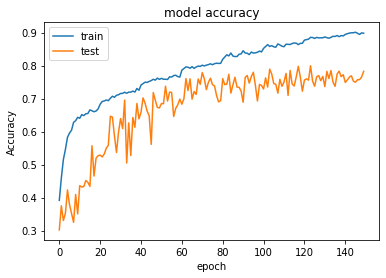

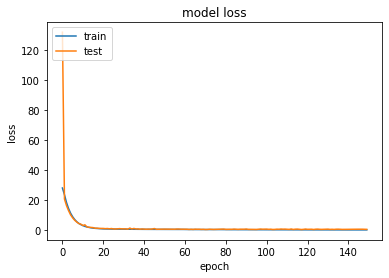

In [10]:
import matplotlib.pyplot as plt
# # visualizing losses and accuracy
print(history.history.keys())
# # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()        

In [12]:
def normalize_data(x):
    mean = 120.707
    std = 64.15
    return (x-mean)/(std+1e-7)

Now normalize_data, user built function is used to normalize instances according to saved stats

In [185]:
#Normalize the test set
x_test = normalize_data(x_test)

In [169]:
print("---  Training time in seconds ---%s " % (time.time() - start_time))
predicted_y = model.predict(x_test, verbose=0)

---  Training time in seconds ---126498.4169986248 


Checking the shapes of prediction made on test set

In [172]:
print(predicted_y)

[[1.1527910e-02 1.5989462e-01 8.2817489e-01 4.0254631e-04]
 [1.1527905e-02 1.5989465e-01 8.2817489e-01 4.0254611e-04]
 [1.1527920e-02 1.5989472e-01 8.2817483e-01 4.0254628e-04]
 ...
 [1.1527920e-02 1.5989476e-01 8.2817483e-01 4.0254628e-04]
 [1.1527915e-02 1.5989466e-01 8.2817483e-01 4.0254628e-04]
 [1.1527910e-02 1.5989466e-01 8.2817483e-01 4.0254591e-04]]


In [174]:
print(y_test)

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [177]:
from sklearn.metrics import confusion_matrix
import pandas as pd

categorical_y_test_labels = pd.DataFrame(y_test).idxmax(axis=1)
categorical_predicted_x = pd.DataFrame(predicted_x).idxmax(axis=1)
    
confusion_matrix(categorical_y_test_labels, categorical_predicted_x)


array([[1123,  327,   47,    0],
       [ 203,  901,   33,    0],
       [ 108,  157, 1147,    1],
       [   1,    0,    5,    3]], dtype=int64)

Defined a user built function that uses LabelBinarizer that binarize the predictions and transform them such that it could be used for roc_auc_score. This is because, the general roc_auc_score is not compatible with multiple classes and is only suitable for binary classification

In [204]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer


def multi_class_roc_auc_score(truth, pred, average="micro"):
    
    lb=LabelBinarizer()
    lb.fit(truth)
    
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    
    return roc_auc_score(truth, pred, average=average)

In [209]:
final_accuracy = accuracy_score(categorical_y_test_labels, categorical_predicted_x)
print('Accuracy: %f' % final_accuracy)
final_precision = precision_score(categorical_y_test_labels, categorical_predicted_x, average='weighted')
print('Precision: %f' %final_precision)
final_recall = recall_score(categorical_y_test_labels, categorical_predicted_x, average='weighted')
print('Recall: %f' %final_recall)
final_f1 = f1_score(categorical_y_test_labels, categorical_predicted_x, average='weighted')
print('F1 Score: %f' %final_f1)
final_roc = multi_class_roc_auc_score(categorical_y_test_labels,categorical_predicted_x)
print('ROC AUC Score: %f' %final_roc)

Accuracy: 0.782544
Precision: 0.797201
Recall: 0.782544
F1 Score: 0.786191
ROC AUC Score: 0.855030


As recall would be used to determine the percentage of correctly identified cell types, recall for a given cell type will be given by, Recall = TP / (TP+FP. )

Recall_Epithelial = TP(epithelial, class: 0)/ (FP(class:1,2,3) + TP(epithelial, class: 0))

In [64]:
Recall_Epi_bestModel = 1123/(1123+203+108+1)
Recall_Fibro_bestModel = 901/(327+901+157+0)
Recall_Inflam_bestModel = 1147/(47+33+1147+5)
Recall_other_bestModel = 3/(0+0+1+3)

print("Recall for epithelial cell-type:      %f" %Recall_Epi_bestModel)
print("Recall for fibroblast cell-type:      %f" %Recall_Fibro_bestModel)
print("Recall for inflammatory cell-type:    %f" %Recall_Inflam_bestModel)
print("Recall for other cell-type:           %f" %Recall_other_bestModel)

Recall for epithelial cell-type:      0.782578
Recall for fibroblast cell-type:      0.650542
Recall for inflammatory cell-type:    0.931006
Recall for other cell-type:           0.750000


#### CONCLUSION:

As the final model is build over 14 trainable layers, with 13 Conventional layers having stride 1 and a single fully connected layer, the number of epochs were also increased from 50 to 100 thus increasing the training time to upto 30 hours. Confusion matrix was plotted to record relevant performance metrics and the model was the best fit model with highest accuracy/recall of 0.78 with roc score as high as 0.855. Though recall was used as the performance metric, with the model predicting 78.25% of the epithelial cell types correctly. The model was able to predict 65% of the fibroblast cell types correctly whereas 93.1% of inflammatory cells were predicted correctly. Apart from that, 75% of other samples were predicted correctly as well thus providing us conclusive evidence of choosing this as our best model for ultimate judgement with recall for all of the cells outperforming the data recorded for earlier models. The ultimate judgement would be based on this model


### ULTIMATE JUDGEMENT
The CNN Model with 14 trainable layers on Patch Images and Image Augmentation provided an improved performance of around 14%, 12% and 31% for predicting epithelial, fibroblast and inflammatory cell type while the model predicts 75% of other samples correctly (though, not much predictions were made thus might not be the best option to predict other samples).Our null hypothesis being, stained images should have helped in improving the performance of our model, based on our research and with conclusive evidence, we are able to reject our null hypothesis. Given the improvement in performance metrics the final model produced, CNN Model with 14 trainable layers on Patch Images and Image Augmentation. was chosen as the final model to predict cell types.